# Práctica 4 - Bordes y Esquinas

## Preparación

Para correr este Jupyter Notebook es necesario tener instalado Octave y octave_kernel, el cual permite utilizar Octave en Jupyter. En Ubuntu se pueden instalar mediante:

```
sudo apt-get install octave
```

y

```
pip3 install octave_kernel
```


## 1. Contaminamos *lena* y *test* con ruido

In [1]:
lena = imread("img/lena256.png");
test = imread("img/test.png");

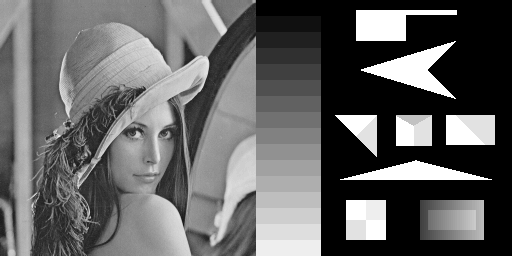

In [2]:
imshow([lena, test])

Definimos las funciones de ruido vistas en la práctica 3:

In [3]:
function res = gaussNoise(img, perc)
    Inoise = normrnd(0, 1, size(img));
    res = img + (Inoise * perc * 255);
endfunction

In [4]:
function res = rayleighNoise(img, epsilon)
    Inoise = sqrt(-epsilon * log(1 - rand(size(img))));
    res = img .* Inoise;
endfunction

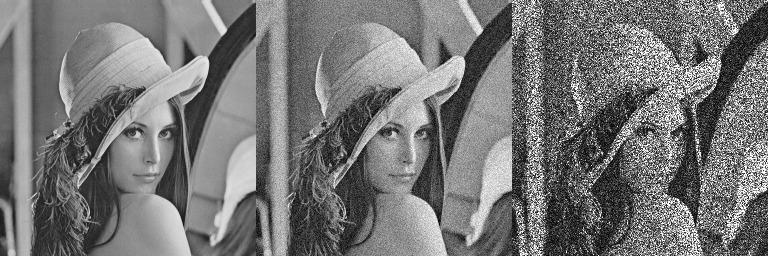

In [5]:
lenaGauss = gaussNoise(lena, 0.05);
lenaRayleigh = rayleighNoise(lena, 1);
imshow([lena, lenaGauss, lenaRayleigh])

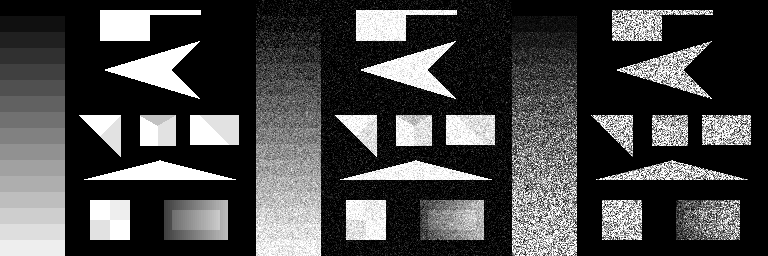

In [6]:
testGauss = gaussNoise(test, 0.1);
testRayleigh = rayleighNoise(test, 1);
imshow([test, testGauss, testRayleigh])

## 2. Detectores de borde

### a. Método del Laplaciano

In [7]:
laplaceKernel = [0 1 0; 1 -4 1; 0 1 0]

laplaceKernel =

   0   1   0
   1  -4   1
   0   1   0



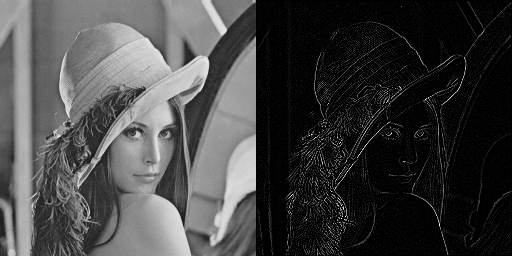

In [8]:
imshow([lena, conv2(lena, laplaceKernel, "same")])

#### Buscamos ahora los ceros en el filtro Laplaciano

In [9]:
filtIm = conv2(lena, laplaceKernel, "same");

El resultado de aplicar la convolución con el kernel Laplaciano es una aproximación a la suma de las derivadas de segundo orden en cada píxel de la imagen:

In [10]:
filtIm(1:10, 1:10)

ans =

  -325  -162  -154  -163  -169  -160  -159  -156  -149  -175
  -162    -4     6    -2    -6    -1    -3     0     7   -16
  -172    10    -2    -3    -7     5     3    -3     3   -12
  -165     4    -9    14    -5   -13    14    13    -8    14
  -142    -5     3    -2    -1     2    -5    -3     6   -10
  -154    -4    -6    30   -16     3     2     2    -7    12
  -161     3    -1    -7     0    -1    10   -17    11    -4
  -160    -5     4     0    -4    -1     5   -12     1    -1
  -155     2    -4    13    -3     3    -3    10    10     1
  -154     6   -13     5    -7     6    -2    -6    -6    -9



Lo que queremos buscar ahora son los cruces de ceros (zero-crossing), es decir, píxeles dónde el signo del laplaciano cambia en su vecindad.

In [11]:
function z = zerocrossings(f)
    zneg = f < 0;
    [R,C] = size(f);
    # z va a ser la matriz booleana de píxeles donde ocurre un cruce de ceros
    z = zeros(R,C);
    # Se marca 1 si un pixel vecino cambia de signo (comparando con zneg)
    z(1:R-1,:) |= zneg(2:R,:);
    z(2:R,:)   |= zneg(1:R-1,:);
    z(:,1:C-1) |= zneg(:,2:C);
    z(:,2:C)   |= zneg(:,1:C-1);
    # Finalmente se queda sólo con los cruces en los puntos no negativos (ceros y positivos)
    # para no contar borde doble (?)
    z &= !zneg;
endfunction

In [12]:
filtIm(1:5, 1:5), zerocrossings(filtIm)(1:5, 1:5)

ans =

  -325  -162  -154  -163  -169
  -162    -4     6    -2    -6
  -172    10    -2    -3    -7
  -165     4    -9    14    -5
  -142    -5     3    -2    -1

ans =

  0  0  0  0  0
  0  0  1  0  0
  0  1  0  0  0
  0  1  0  1  0
  0  0  1  0  0



#### Detector de bordes Laplaciano

Para detectar bordes con el filtro Laplaciano:
1. Convoluciona la imagen con el kernel Laplaciano, para obtener las derivadas parciales de segundo orden
2. Busca los cruces de ceros en la matriz Laplaciana
3. Aplica un umbral sobre los valores absolutos de la matriz, para quedarse con los píxeles de borde de "alto contraste", dado que el método es susceptible a ruido.

In [13]:
function res = edgeLaplace(img)
    f = [0 1 0; 1 -4 1; 0 1 0];
    # Aplica filtro Laplaciano
    g = conv2(img, f, "same");
    # Busca los cruces de ceros y aplica umbral
    thres = mean(abs(g));
    res = zerocrossings(g) & (abs(g) > thres);
endfunction

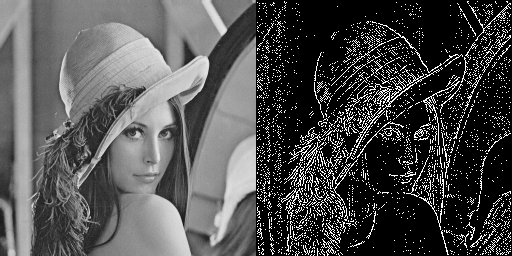

In [14]:
imshow([lena, edgeLaplace(lena)*255])

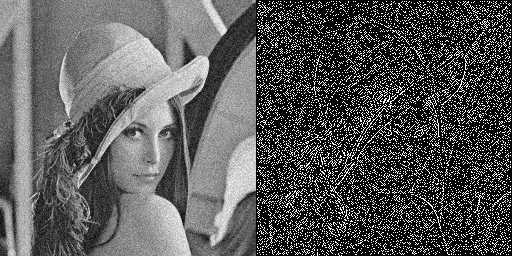

In [15]:
imshow([lenaGauss, edgeLaplace(lenaGauss)*255])

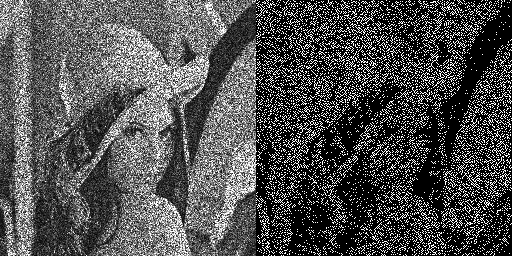

In [16]:
imshow([lenaRayleigh, edgeLaplace(lenaRayleigh)*255])

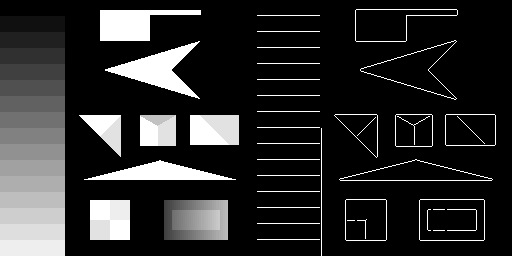

In [17]:
imshow([test, edgeLaplace(test)*255])

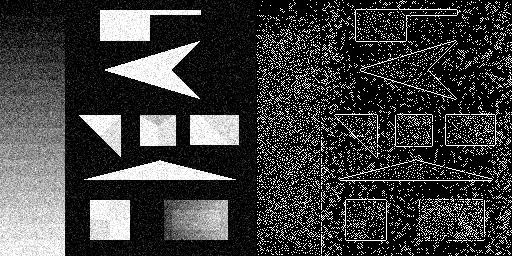

In [18]:
imshow([testGauss, edgeLaplace(testGauss)*255])

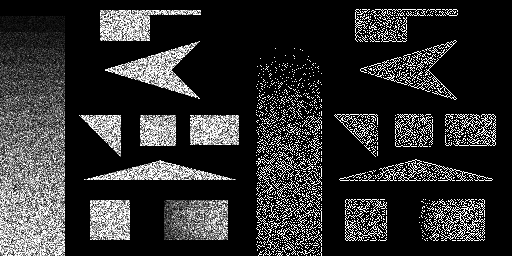

In [19]:
imshow([testRayleigh, edgeLaplace(testRayleigh)*255])

### c. Método del Laplaciano del Gaussiano

El método de detección de bordes es similar, pero aplicando un filtro gaussiano antes del Laplaciano...

In [20]:
function res = edgeLoG(img)
    # Aplica un filtro gaussiano 5x5
    f = [1,4,6,4,1; 4,16,24,16,4; 6,24,36,24,6; 4,16,24,16,4; 1,4,6,4,1]/256;
    g = conv2(img, f, "same");
    # Busca bordes con Laplace
    res = edgeLaplace(g);
endfunction

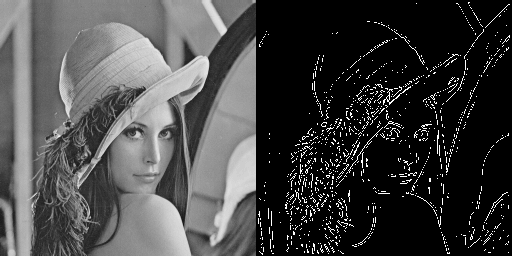

In [21]:
img = lena;
imshow([img, edgeLoG(img)*255])

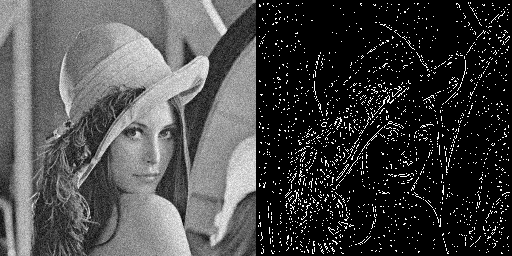

In [22]:
img = lenaGauss;
imshow([img, edgeLoG(img)*255])

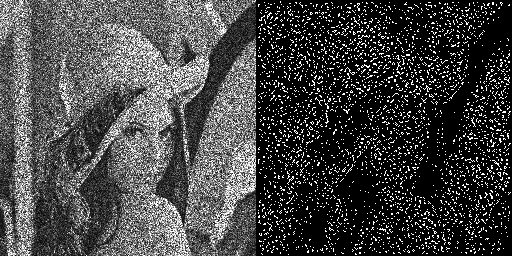

In [23]:
img = lenaRayleigh;
imshow([img, edgeLoG(img)*255])

## 3. Método de Canny

In [24]:
lena = imread("img/lena256.png");

### Filtro gaussiano

Primero aplicamos un filtro gaussiano para eliminar ruido. Generamos un kernel $5 \times 5$ con $\sigma=\sqrt 2$

In [25]:
% 5x5 gaussian kernel (sigma=sqrt(2)) generated with the "image" package:
%   pkg load image;
%   gauss = fspecial("gaussian", 5, sqrt(2))
gauss = [
   0.012478   0.026415   0.033918   0.026415   0.012478
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.033918   0.071804   0.092198   0.071804   0.033918
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.012478   0.026415   0.033918   0.026415   0.012478
]

gauss =

   0.012478   0.026415   0.033918   0.026415   0.012478
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.033918   0.071804   0.092198   0.071804   0.033918
   0.026415   0.055921   0.071804   0.055921   0.026415
   0.012478   0.026415   0.033918   0.026415   0.012478



In [26]:
function res = gaussian(img)
    gauss = [
       0.012478   0.026415   0.033918   0.026415   0.012478
       0.026415   0.055921   0.071804   0.055921   0.026415
       0.033918   0.071804   0.092198   0.071804   0.033918
       0.026415   0.055921   0.071804   0.055921   0.026415
       0.012478   0.026415   0.033918   0.026415   0.012478
    ];
    res = conv2(img, gauss, "same");
endfunction

### Obtención del gradiente y orientación

Ahora calculamos las derivadas parciales con diferentes filtros:

1. Roberts
2. Sobel
3. Prewitt

Luego calculamos el gradiente y orientación a partir de cada una de ellas.

In [27]:
function [Ig, Io] = gradient(img, filterX, filterY)
    Ix = conv2(img, filterX, "same");
    Iy = conv2(img, filterY, "same");
    Ig = sqrt(Ix .^ 2 + Iy .^ 2);
    Io = atan2(Ix, Iy);
endfunction

#### Roberts

In [37]:
FilterRobertsX = [1 0 0; 0 -1 0; 0 0 0];
FilterRobertsY = [0 1 0; -1 0 0; 0 0 0];

#### Sobel

In [38]:
FilterSobelX = [1 2 1; 0 0 0; -1 -2 -1];
FilterSobelY = rot90(FilterSobelX, 3);

#### Prewitt

In [39]:
FilterPrewittX = [-1 -1 -1; 0 0 0; 1 1 1];
FilterPrewittY = rot90(FilterPrewittX, 3);

### Supresión de no máximos

Definimos ahora la función de supresión de no máximos, para eliminar múltiples respuestas de borde sobre la imagen de gradiente generada en cada filtro.

In [41]:
function res = nonmax_suppresion(Ig, Io)
    res = zeros(size(Ig));
    [filas, columnas] = size(Ig);
   
    for i = 2 : filas-1
        for j = 2 : columnas-1
            anguloEnDeg = Io(i,j) * 180/pi;
            if (anguloEnDeg < 45 && anguloEnDeg > -45)
                if Ig(i,j) > max(Ig(i-1,j), Ig(i+1,j))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > 45 && anguloEnDeg < 135)
                if Ig(i,j) > max(Ig(i+1,j-1), Ig(i-1,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > 135 || anguloEnDeg < -135)
                if Ig(i,j) > max(Ig(i,j-1), Ig(i,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
            if (anguloEnDeg > -135 && anguloEnDeg < -45)
                if Ig(i,j) > max(Ig(i-1,j-1),Ig(i+1,j+1))
                    res(i,j)=Ig(i,j);
                end
            end
        end
    end
endfunction

A continuación aplicamos el proceso a las imágenes contaminadas con ruido gaussiano y Rayleigh de "Lena" y "Test", con los filtros Roberts, Sobel y Prewitt y comparamos los resultados:

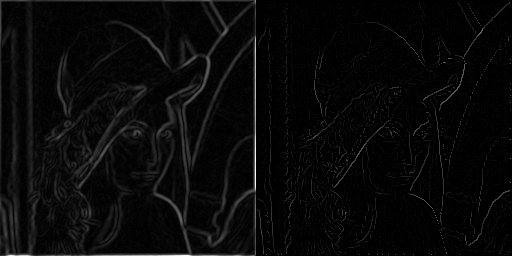

In [50]:
[Ig, Io] = gradient(gaussian(lenaGauss), FilterRobertsX, FilterRobertsY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

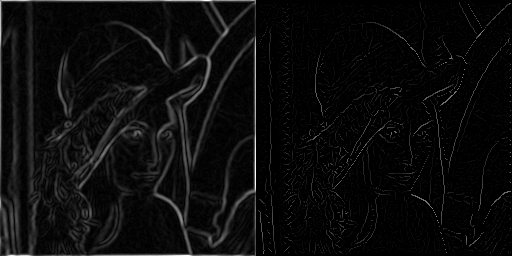

In [51]:
[Ig, Io] = gradient(gaussian(lenaGauss), FilterSobelX, FilterSobelY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

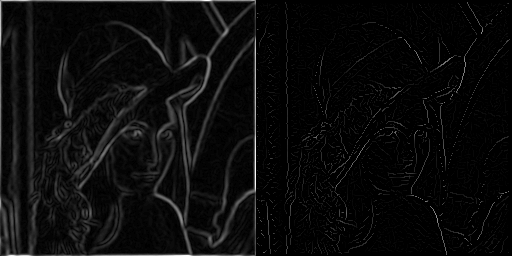

In [52]:
[Ig, Io] = gradient(gaussian(lenaGauss), FilterPrewittX, FilterPrewittY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

Se puede observar que la elección del filtro de bordes no afecta tanto a los resultados, pero la aplicación de la supresión de no máximos efectivamente elimina los bordes múltiples causados por el filtro gaussiano inicial en la magnitud del gradiente. El ruido gaussiano que tenía la imagen fue practicamente eliminado.

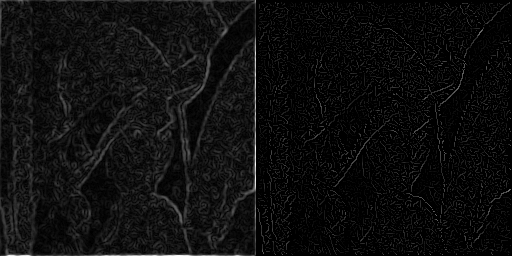

In [49]:
[Ig, Io] = gradient(gaussian(lenaRayleigh), FilterRobertsX, FilterRobertsY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

Aplicando el mismo proceso sobre la imagen contaminada con ruido Rayleigh, el efecto de la supresión es similar.

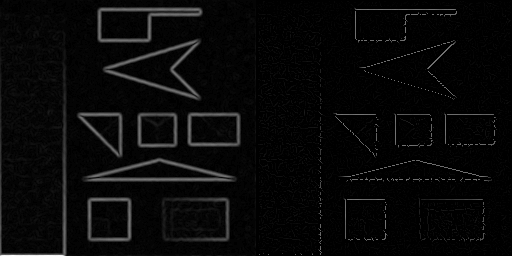

In [47]:
[Ig, Io] = gradient(gaussian(testGauss), FilterRobertsX, FilterRobertsY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

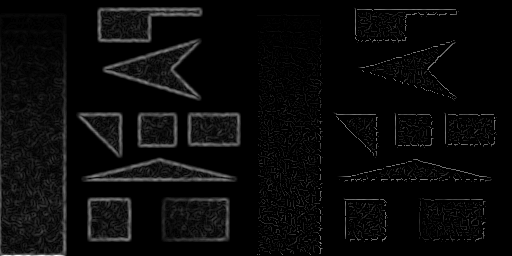

In [48]:
[Ig, Io] = gradient(gaussian(testRayleigh), FilterRobertsX, FilterRobertsY);
imshow([Ig, nonmax_suppresion(Ig, Io)]);

En el caso de la imagen "Test", también queda claro que la supresión nos deja un borde simple sobre las figuras. A pesar de lo dificil que parecía eliminar el ruido Rayleigh en esta imagen, el filtro gaussiano + la supresión ayuda bastante en reconocer los bordes de las figuras y elminar las falsas respuestas de bordes dentro de ellas.

### Histéresis de Umbral

Para la última etapa del detector de bordes de Canny, se implementa una umbralización por histéresis para eliminar ruido en el resultado de supresión de no máximos. Lamentablemente la implementación que escribimos hace uso de una **pila** para guardar las coordenadas visitadas, y como Octave/Matlab no tiene esta estructura de datos, recurrimos a Python para este proceso.

El código de Python es el siguiente y se encuentra en el archivo `hyst.py`:

```python
#!/usr/bin/env python3
import numpy as np
from imageio import imread, imwrite
from scipy.io import loadmat, savemat

def hist_thresh(infile, outfile, orientation, low, high):
    Im = np.loadtxt(infile)
    Io = np.loadtxt(orientation)

    rows, cols = np.nonzero(Im > high)
    S = list(zip(rows, cols))

    out = np.zeros(Im.shape, dtype=np.uint8)

    while S:
        r, c = S.pop()
        if out[r, c] > 0:
            continue

        # Mark as border
        out[r, c] = 255

        # Convert angle in radians to degrees
        angle = Io[r, c] * 180 / np.pi;

        # Grow region if magnitude exceeds low threshold
        if angle < 45 and angle > -45:
            if Im[r-1, c] > low:
                S.append((r-1, c))
            if Im[r+1, c] > low:
                S.append((r+1, c))
        elif angle > 45 and angle < 135:
            if Im[r-1, c-1] > low:
                S.append((r-1, c-1))
            if Im[r+1, c+1] > low:
                S.append((r+1, c+1))
        elif angle > 135 and angle < -135:
            if Im[r, c-1] > low:
                S.append((r, c-1))
            if Im[r, c+1] > low:
                S.append((r, c+1))
        elif angle > -135 and angle > -45:
            if Im[r-1, c+1] > low:
                S.append((r-1, c+1))
            if Im[r+1, c-1] > low:
                S.append((r+1, c-1))

    imwrite(outfile, out)

if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(
            description='Apply hysteresis thresholding on image',
            formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument('input',
            help='path to input image file')
    parser.add_argument('output',
            help='path to output image file')

    parser.add_argument('orientation',
            help='path to image of gradient orientation')
    parser.add_argument('low', type=int, help='low threshold')
    parser.add_argument('high', type=int, help='high threshold')

    args = parser.parse_args()

    hist_thresh(args.input, args.output, args.orientation, args.low, args.high)


```

Definimos una función en Octave para ejecutar este script dada una imagen de magnitud del gradiente (el resultado de supresión de no máximos), la imagen de orientación del gradiente, y las variables `low` y `high` que determinan los umbrales bajos y altos respectivamente. Para interactuar con Python, escribimos las matrices en archivos y hacemos que el script de python lea las matrices y escriba otra con la salida del algoritmo. Luego leemos nuevamente la salida para retornar la matriz resultado.

In [65]:
function res = rescale(img)
    res = (img - min(min(img))) * 255 / (max(max(img)) - min(min(img)));
endfunction

In [66]:
function res = hyst_thresh(Im, Io, low, high)
    outfile = "/tmp/out.png";
    infile = "/tmp/in.txt";
    orientation = "/tmp/orient.txt";
    
    save(infile, 'Im', '-ascii')
    save(orientation, 'Io', '-ascii')
    
    cmd = ["python3 hyst.py " infile " " outfile " " orientation " " num2str(low) " " num2str(high)]
    system(cmd);
    
    res = rescale(imread(outfile));
endfunction

Volvemos a hacer una comparación de las imágenes de Lena y Test del punto anterior, esta vez aplicando como último paso la umbralización por histéresis.

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 5 20


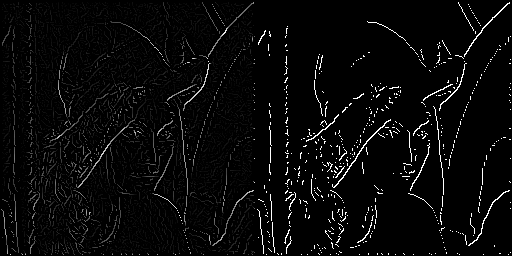

In [69]:
[Ig, Io] = gradient(gaussian(lenaGauss), FilterRobertsX, FilterRobertsY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 5, 20)]);

Podemos ver que eligiendo unos umbrales bajos y altos apropiados se pueden obtener muy buenos resultados para Lena, dejando solo los bordes más importantes, a tal punto de que la persona en la fotografía es reconocible.

En el caso de la misma imagen contaminada con ruido Rayleigh, la situación es más complicada, pero nuevamente siendo más restrictivo en los umbrales, los resultados se pueden mejorar:

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 5 20


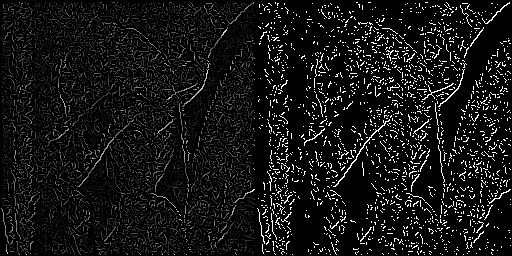

In [81]:
[Ig, Io] = gradient(gaussian(lenaRayleigh), FilterRobertsX, FilterRobertsY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 5, 20)]);

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 17 25


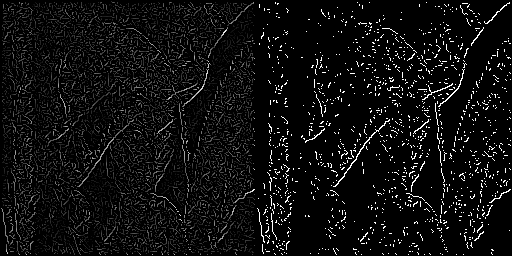

In [82]:
[Ig, Io] = gradient(gaussian(lenaRayleigh), FilterRobertsX, FilterRobertsY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 17, 25)]);

Para el caso de "Test", inmediatamente observamos que la elección del filtro tiene un claro efecto en el resultado final de los bordes detectados. El filtro Roberts es el que da mejores resultados, bordes más exactos en el caso de las figuras. También es importante aclarar que la elección de los valores de umbrales depende del filtro utilizado.

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 15 30


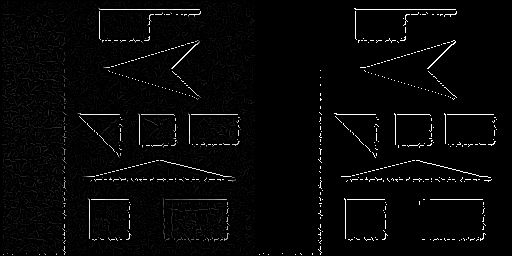

In [92]:
[Ig, Io] = gradient(gaussian(testGauss), FilterRobertsX, FilterRobertsY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 15, 30)]);

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 10 80


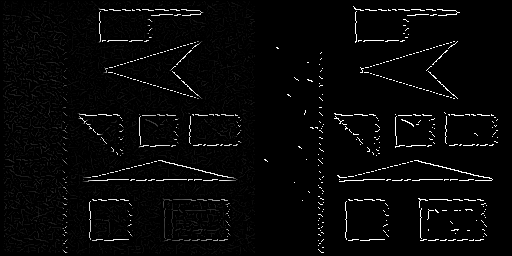

In [100]:
[Ig, Io] = gradient(gaussian(testGauss), FilterSobelX, FilterSobelY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 10, 80)]);

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 10 80


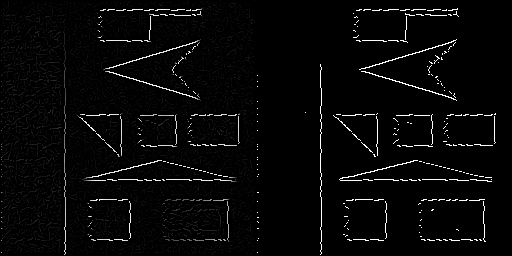

In [103]:
[Ig, Io] = gradient(gaussian(testGauss), FilterPrewittX, FilterPrewittY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 10, 80)]);

En caso de la imagen contaminada con ruido Rayleigh los resultados son similares. Eligiendo un umbral alto nos permite eliminar el ruido dentro contenido dentro de las figuras.

cmd = python3 hyst.py /tmp/in.txt /tmp/out.png /tmp/orient.txt 15 50


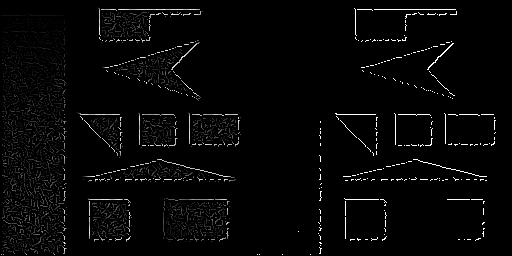

In [105]:
[Ig, Io] = gradient(gaussian(testRayleigh), FilterRobertsX, FilterRobertsY);
Inonmax = nonmax_suppresion(Ig, Io);
imshow([rescale(Inonmax), hyst_thresh(Inonmax, Io, 15, 50)]);

# 3. Detección de esquinas 

## Harris

Para realizar la detección de esquinas de Harris tuvimos que usar Matlab, ya que Octave con Jupyter tenían ciertos problemas para ejecutarlo. Por tanto, ponemos aquí el código, y mostramos los resultados de haberlo corrido en Matlab. A su vez, se entrega el archivo harris.m que lo implementa


```Octave
limiteR = 1000000;
tamanio_gauss = 5;
k=0.05;

Gx = [1   2   1;0   0   0;-1  -2  -1];
Gy = [-1   0   1;-2   0   2; -1   0   1];
Gxy = Gx .* Gy;
gauss = fspecial("gaussian", [tamanio_gauss tamanio_gauss]);


I = imread('img/test.png');

filas = size(I, 1);
columnas = size(I, 2);

% 1) Calculamos derivadas de I en x y en y
Ix = conv2(Gx, I);
Iy = conv2(Gy, I);


% 2) Generamos Ix2, Iy3, Ixy
Ix2 = Ix .^ 2;
Iy2 = Iy .^ 2;
Ixy = Ix .* Iy;

% 3) Convolucionamos con una gaussiana
Sx2 = conv2(Ix2, gauss);
Sy2 = conv2(Iy2, gauss);
Sxy = conv2(Ixy, gauss);

output = zeros(filas, columnas);
for x=1:filas,
   for y=1:columnas,
       % 4) Calculamos la matriz M
       H = [Sx2(x, y) Sxy(x, y); Sxy(x, y) Sy2(x, y)];
       
       % 5) A partir de M calculamos R
       % det(H) = lambda1*lambda2
       % trace(H) = lambda1+lambda2
       R = det(H) - k * (trace(H));
       
       % 6) Verificamos si R supera el limite
       if (R > limiteR)
          output(x, y) = R; 
       end
   end
```

Analizamos Lena y Test con Harris. Los parametros que usamos fueron:
* limite de R para clasificar como esquina = 1000000
* Tamaño de convolución de gauss =  5;
* k = 0.05

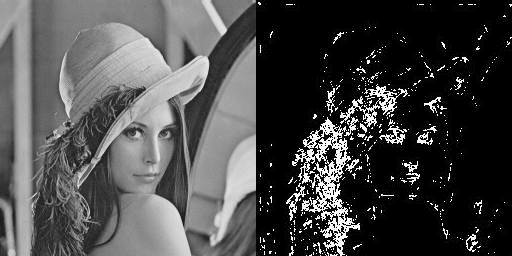

In [4]:
lena = imread("img/lena256.png");
lenaHarris = imread("img/lenaHarris.jpg");
imshow([lena, lenaHarris]);

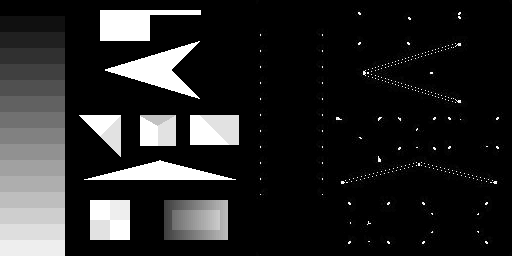

In [5]:
test = imread("img/test.png");
testHarris = imread("img/testHarris.jpg");
imshow([test, testHarris]);

Observamos que en ambas imágenes obtenemos buenos resultados. Esto se debe a que fuimos variando las variables (tamaño del kernel gaussiano y límite del R) hasta encontrar buena combinación.


## Szeliski

Notamos que Szeliski es muy parecido a Harris, pero redefiniendo el cálculo del R. En Harris teníamos:
```
R = det(H) - k * (trace(H));
```
Mientras que en Szeliski tenemos:
```
R = det(H) / trace(H);
```

El código completo de Szeliski utilizado en este TP se puede ver en el archivo szeliski.m

Procesamos entonces Lena y Test con Szeliski. Utilizamos los parámetros:
* Limite de R = 100
* Tamaño de kernel guassiano = 5

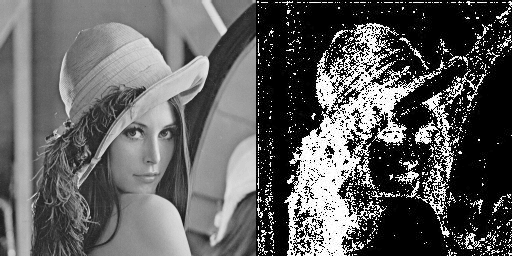

In [6]:
lena = imread("img/lena256.png");
lenaSzeliski = imread("img/lenaSzeliski.jpg");
imshow([lena, lenaSzeliski]);

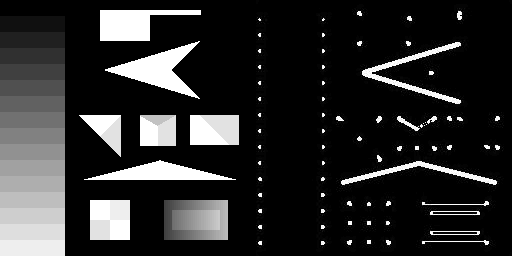

In [7]:
test = imread("img/test.png");
testSzeliski = imread("img/testSzeliski.jpg");
imshow([test, testSzeliski]);

En este algoritmo probamos además bajar el umbral de R, para notar qué ocurre con ambas imágenes cuando permitimos clasificar a más puntos como esquinas.

## Triggs

Triggs también es muy parecido a Harris, pero redefiniendo el cálculo del R. En Harris teníamos:
```
R = det(H) - k * (trace(H));
```
Mientras que en Triggs tenemos:
```
R = (lambda1 - alpha * lambda2);
```
Con lambda1 y lambda2 como los autovalores de H, y alpha un parámetro a definir.

El código completo de Triggs utilizado en este TP se puede ver en el archivo triggs.m

Los parámetros para Triggs fueron:
* Alpha = 0.5
* Limite de R = 100
* Tamaño del kernel gaussiano = 5
* k = 0.05

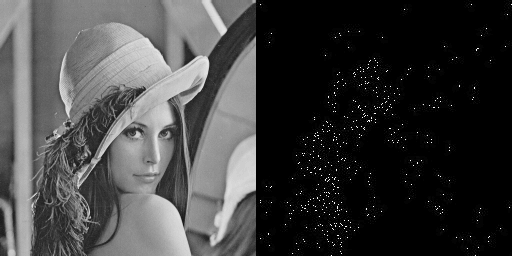

In [14]:
lena = imread("img/lena256.png");
lenaTriggs = imread("img/lenaTriggs.jpg");
imshow([lena, lenaTriggs]);

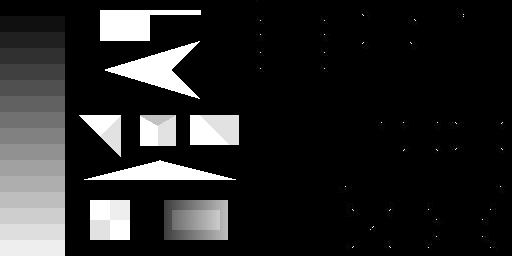

In [9]:
test = imread("img/test.png");
testTriggs = imread("img/testTriggs.jpg");
imshow([test, testTriggs]);

En este algoritmo decidimos también bajar un poco el umbral de R, para ver qué ocurre cuando hacemos más restrictiva la clasificación de un punto en una esquina.

## Shi - Tomasi

Por último probamos con Shi - Tomasi, que también redefine el cálculo del R. En Harris teníamos:
```
R = det(H) - k * (trace(H));
```
Mientras que en Shi - Tomasi tenemos:
```
R = lambda1;
```
Con lambda1 el mayor autovalor  de H. (Notamos que este algoritmo es un caso específico de Triggs, con alpha = 0).

El código completo de Shi - TOmasi utilizado en este TP se puede ver en el archivo ShiTomasi.m

Los parámetros utilizados fueron:
* Límite de R = 1000
* Tamaño de kernel gaussiano = 5 
* k = 0.05

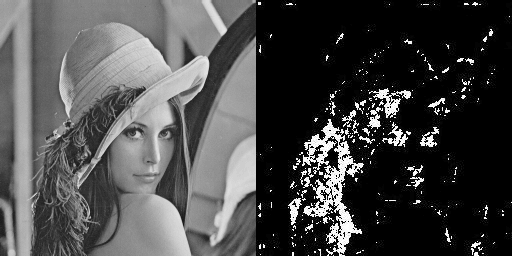

In [16]:
lena = imread("img/lena256.png");
lenaShiTomasi = imread("img/lenaShiTomasi.jpg");
imshow([lena, lenaShiTomasi]);

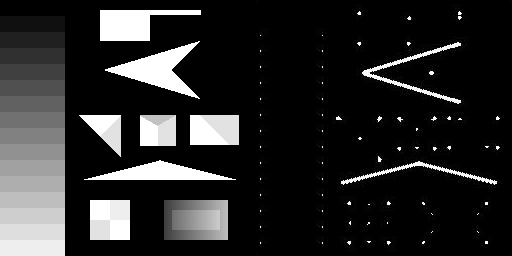

In [17]:
test = imread("img/test.png");
testShiTomasi = imread("img/testShiTomasi.ajpg");
imshow([test, testShiTomasi]);

En este último caso decidimos utilizar un umbral de R moderado. Notamos que se comporta de manera levemente distinta a los otros.

**Para concluir sobre estos 4 algoritmos**, mencionamos que cada uno tiene distintos factores y umbrales para R, los cuales fuimos variando para notar las posibilidades que nos otorgan.

Notamos que, a medida que somos más permisivos con los puntos para clasificarlos como esquinas, notamos más el rostro de lena, y obtenemos hasta puntos como esquinas en el fondo. Además, a medida que bajamos el umbral de R, las esquinas obtenidas con umbrales altos se ven más densas, o sea, cada píxel cerca de una esquina se ve clasificado como esquina también (esto se aprecia más en la imagen de test).